# **Projeto: Percolação por sítios em rede quadrada**
### **Programação Estatística - Projeto de Fim de Curso**

- Docente: Rafael Izbicki
- Discentes:
    - Andressa Nascimento Santos - RA 829442
    - Nicolas Magalhães Santana e Silva - RA 830225

---

# **Introdução**

A teoria da percolação é um modelo fundamental para descrever fenômenos de conexão em sistemas desordenados, como o fluxo de líquidos em meios porosos, a propagação de incêndios florestais ou a condutividade em materiais compósitos.

O objetivo deste projeto é estimar, por meio de simulação de Monte Carlo, o limiar crítico de percolação $p_c$ em uma grade quadrada bidimensional e analisar o comportamento do sistema próximo a esse ponto crítico.

As principais questões são:
- Qual o valor de $p$ a partir do qual um "caminho" de ponta a ponta na grade se torna provável?
- Como essa probabilidade varia com o tamanho da grade ($N$)?
- Qual a distribuição de tamanho do maior aglomerado _(cluster)_ de sítios conectados, especialmente no limiar crítico?

---

# **Descrição do modelo gerador de dados**

## Orientações
O modelo é uma grade (ou reticulado) quadrada $\mathcal{L}$ de dimensões $N \times X$. Cada sítio $(i, j) \in \mathcal{L}$ pode estar em um de dois estados: "ocupado" ou "vazio". A ocupação de cada sítio é um evento independente de Bernoulli com probabilidade $p$, ou seja, $P(\text{sítio }(i, j)\text{ ocupado})=p$.

Um _cluster_ é definido como um conjunto de sítios ocupados adjacentes (vizinhos de von Neumann: acima, abaixo à esquerda, à direita). 

Diz-se que o sistema "percola" se existir um cluster que conecte a borda superior à borda inferior da grade (ou a esquerda à direita).

A probabilidade de percolação, $\theta(p,N)$, é a probabilidade de que uma grade $N \times N$ gerada com parâmetro $p$ percole.

O limiar crítico $p_c$ é definido no limite $N \rightarrow \infty$ como o valor de $p$ em que $\theta(p)$ transita de $0$ para $1$.

## Execução

Para por em prática o modelo gerador de dados, utilizamos as seguintes bibliotecas Python: **NumPy, Matplotlib e SciPy** (da qual foi importado especificamente o pacote `ndimage`, para identificação de clusters em grades)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

Para fins de replicabilidade, incluímos em toda execução de código deste Notebook Python uma **semente fixa**, que foi escolhida como o número `42` e estabelecida com o comando ``np.random.seed(42)``.

---

# **Metodologia da simulação**

## Orientações:
A simulação seguirá os seguintes passos para um dado par $(N, p)$:
1. **Geração da Grade:** Crie uma matriz $N \times N$ e preencha cada célula com $1$ (ocupado) com probabilidade $p$ e $0$ (vazio) com probabilidade $1-p$.

2. **Verificação de Percolação:** Verifique se, na configuração gerada, é possível ir da borda inferior para a superior.

3. **Estimação de $p_c(N)$**: Para um dado $N$, a probabilidade de percolação $\theta(p, N)$ será estimada pela frequência de percolação em um grande número de simulações. O limiar finito, $p_c(N)$, é tipicamente definido como o valor de $p$ para o qual $θ(p, N) \approx \frac{1}{2}$. Isso pode ser encontrado varrendo $p$ em uma malha fina ou usando um método de busca (e.g., busca binária) para encontrar o ponto de cruzamento. A extrapolação para o limite $N \rightarrow \infty$ pode ser investigada através da teoria de escala de tamanho finito, plotando $p_c(N)$ versus $1/N$ e analisando o comportamento assintótico.

## Execução

### **Algoritmo de simulação de percolação**
Nesse algoritmo, realizamos os passos 1 (Geração da grade) e 2 (Verificação de percolação).

No código, uma grade, em forma de matriz, é gerada aleatoriamente utilizando o NumPy e etiquetada através do pacote `ndimage` do SciPy.

A partir da matriz etiquetada, verificamos se houve ou não percolação no sistema conferindo a existência de intersecções entre etiquetas de clusters na primeira e última linhas da matriz, ou na primeira e última coluna da matriz. Caso haja intersecções, é retornado que o sistema percolou.

Outras métricas retornadas pelo algoritmo são o número de clusters e o tamanho do maior cluster (isto é, número de sítios ocupados pelo maior cluster). O número de clusters é obtido através do retorno da função que etiqueta os clusters -- `ndimage.label` --, que também identifica a quantidade de elementos diferentes na matriz etiquetada (excluindo o número $0$, que representa sítios vazios). Já o tamanho do maior cluster é registrado pela identificação de qual a maior frequência de aparecimento dentre os elementos que compõem a matriz etiquetada, também excluindo as aparições do número $0$.

In [5]:
def simulacao_percolacao(N, p):
  ''' Recebe os parâmetros N (o tamanho da matriz será NxN) e p (probabilidade da entrada da matriz ser 1, e 0 caso contrário).
Retorna se a matriz percolou, o número de clusters e o tamanho do maior cluster'''
  percolou = False
  maior_cluster = 0
  num_clusters = 0

  grade = np.random.rand(N, N) < p
  grade = np.where(grade, 1, 0)
  if not np.any(grade):
    return False, 0, 0
  # Se a matriz for inteiramente de zeros, já retorna que não percola e não teve clusters

  estrutura = ndimage.generate_binary_structure(rank=2, connectivity=1)
  # Define a estrutura de Vizinhos de von Neumann que será utilizada para identificar os clusters nas grades

  grade_clusters, num_clusters = ndimage.label(grade, estrutura)
  # Função de etiquetar as matrizes em clusters
  coluna_1 = grade_clusters[:, 0]
  coluna_n = grade_clusters[:, -1]
  linha_1 = grade_clusters[0]
  linha_n = grade_clusters[-1]

  intersecoes_vertical = np.intersect1d(linha_1, linha_n)
  intersecoes_horizontal = np.intersect1d(coluna_1, coluna_n)

  percolou_vertical = np.any(intersecoes_vertical > 0)
  percolou_horizontal = np.any(intersecoes_horizontal > 0)
  if percolou_vertical or percolou_horizontal:
    percolou = True

  grade_clusters_d1 = np.ravel(grade_clusters)

  contagem = np.bincount(grade_clusters_d1)
  # Conta ocupação de cada etiqueta de cluster
  maior_cluster = max(contagem[1:])
  # Maior cluster é o elemento que ocupou mais sítios (excluindo o zero)

  return percolou, maior_cluster, num_clusters, grade, grade_clusters

#### Exemplo do algoritmo de simulação para um sistema aleatório com $N=7$ e $p=0.5$

In [5]:
np.random.seed(42)
perc, maior, num, grade, grade_clusters = simulacao_percolacao(7, 0.5)
print(f"Matriz gerada aleatoriamente: \n {grade} \n")

print(f"Matriz etiquetada: \n {grade_clusters} \n")

print(f"O sistema percolou? {perc}")
print(f"Qual o tamanho do maior cluster? {maior}")
print(f"Qual o número total de clusters? {num}")

Matriz gerada aleatoriamente: 
 [[1 0 0 0 1 1 1]
 [0 0 0 1 0 0 1]
 [1 1 1 0 1 1 0]
 [1 1 1 1 0 1 0]
 [0 1 0 1 1 0 0]
 [0 1 1 0 1 1 1]
 [1 0 1 0 1 0 0]] 

Matriz etiquetada: 
 [[1 0 0 0 2 2 2]
 [0 0 0 3 0 0 2]
 [4 4 4 0 5 5 0]
 [4 4 4 4 0 5 0]
 [0 4 0 4 4 0 0]
 [0 4 4 0 4 4 4]
 [6 0 4 0 4 0 0]] 

O sistema percolou? True
Qual o tamanho do maior cluster? 17
Qual o número total de clusters? 6


### **Métricas estimadas sobre clusters a partir da simulação**

Nessa função, estimamos métricas a respeito dos clusters para cada sistema $N \times N$ e probabilidade $p$, a partir do método de Monte Carlo com um número $M$ de réplicas.

As métricas estimadas incluem: tamanho dos maiores clusters, tamanho médio dos maiores clusters, número de clusters, média do número de clusters e probabilidade de percolar para cada terna $(N, p, M)$ para os casos de percolação ou não percolação dos sistemas.

In [ ]:
def metricas_cluster(N, p, M):
  ''' Recebe os parâmetros N (o tamanho da matriz será NxN), p (probabilidade da entrada da matriz ser 1, e 0 caso contrário) e
  M (número de amostras a serem geradas). Retorna métricas sobre as matrizes que percolam e que não percolam, separadamente:
  o tamanho dos maiores clusters, a probabilidade de percolar/não percolar, a média do tamanho dos maiores clusters, total de
  matrizes que percolam ou não e média do total de clusters.'''

  tam_cluster_percola = []
  tam_cluster_nao_percola = []
  num_cluster_percola = []
  num_cluster_nao_percola = []
  total_percola, total_nao_percola = 0, 0
    
  for i in range(M):
    y = simulacao_percolacao(N, p)
    if y[0] == True:
      tam_cluster_percola.append(y[1])
      num_cluster_percola.append(y[2])
      total_percola += 1
    else:
      tam_cluster_nao_percola.append(y[1])
      num_cluster_nao_percola.append(y[2])
      total_nao_percola += 1

  prob_percolar = total_percola / M
  prob_nao_percolar = 1 - prob_percolar

  media_tam_percola = sum(tam_cluster_percola) / total_percola if total_percola else 0
  media_tam_nao_percola = sum(tam_cluster_nao_percola) / total_nao_percola if total_nao_percola else 0

  media_num_percola = sum(num_cluster_percola) / total_percola if total_percola else 0
  media_num_nao_percola = sum(num_cluster_nao_percola) / total_nao_percola if total_nao_percola else 0
    
  return tam_cluster_percola, tam_cluster_nao_percola, prob_percolar, prob_nao_percolar, media_tam_percola, media_tam_nao_percola, total_percola, total_nao_percola, num_cluster_percola, num_cluster_nao_percola, media_num_percola, media_num_nao_percola

### **Algoritmo de estimação de limiares finitos por bissecção**

Nesse algoritmo, usamos a métrica de probabilidade de um sistema percolar ($\theta(p,N)$) estimada na função anterior para encontrar, através do método da bissecção, um valor estimado de $p$ para o qual a $\theta(p,N)$ de um sistema $N \times N$ seja igual a $0.5$. Em outras palavras, realizamos nesse algoritmo o passo 3, onde usamos o método da bissecção para estimar um limiar finito $p_c(N)$.

Adotamos arbitrariamente um erro de $0.01$ para a bissecção.

In [11]:
def encontrar_limiar(N, M):
    def f(N, x, M):
        return metricas_cluster(N, x, M)[2]  # retorna probabilidade de percolar

    a, b = 0, 1
    x = (a + b)/2
    erro = 0.01

    while abs(f(N, x, M)-0.5) > erro:
        resultado = f(N, x, M)
        if resultado < 0.5:
            a = x
        elif resultado > 0.5:
            b = x
        x = (a + b)/2
    return x

---

# **Plano de experimento e métricas**

## Orientações

- **Tamanhos da grade:** Realize simulações para $N \in \{64, 128, 256, 512\}$.

- **Varredura de p:** Para cada $N$, execute simulações para uma faixa de valores $p$. Para cada par $(N, p)$, realize pelo menos $M = 500$ réplicas.

- **Métricas a coletar:** Para cada simulação, registre: (a) se houve percolação (booleano), (b) o tamanho do maior cluster, (c) o número total de clusters.

- **Análise do maior cluster:** No valor estimado $\widehat{p_c}(N)$, colete a distribuição empírica do tamanho do maior cluster em múltiplas simulações.

## Execução

Com o objetivo de estimar o limiar crítico, utilizamos a função `encontrar_limiar` (que aplica diretamente as métricas coletadas anteriormente a partir de simulações), para criar uma nova função que encontra os limiares finitos para sistemas de tamanho $N \in \{16, 64, 128, 256, 512, 1024\}$ com número de réplicas $M$.

A partir desses dados, o limiar crítico com $N \rightarrow \infty$ será estimado através de análise da convergência assintótica do gráfico de limiares finitos versus $N$ para um número grande de amostras $M$.

In [8]:
def limiar_critico(M):
  ''' Recebe como parâmetro o número de amostras (M) que serão replicadas e retorna o gráfico com a interseção entre
  os valores de N e seu limiar finito empírico'''
  lista_N = [16, 64, 128, 256, 512, 1024]
  lista_limiares = []

  for N in lista_N:
    x = encontrar_limiar(N, M)
    lista_limiares.append(x)

  plt.figure(figsize=(8,8))
  plt.xlabel('N')
  plt.ylabel('Limiar pc(N)')
  plt.title(f'Limiares finitos versus N')
  plt.plot(lista_N, lista_limiares, marker='o')
  for x, y in zip(lista_N, lista_limiares):
    plt.text(x, y, f"({x}, {y:.5f})", ha='left', va='bottom')
  plt.grid(True)
  plt.show()

---

# **Resultados**

### **Estimação do limiar crítico com $N \rightarrow \infty$**

Como detalhado anteriormente, a estimação do limiar crítico $\widehat{p_c}(N)$ com $N \rightarrow \infty$ foi feita invocando a função `limiar_critico` para um número $M=500$ de réplicas. Após análise da convergência assintótica do gráfico em diversos experimentos como o ilustrado abaixo, coletamos o resultado de que $\boxed{\widehat{p_c}(N) \approx 0.5915}$ a medida em que $N \rightarrow \infty$.

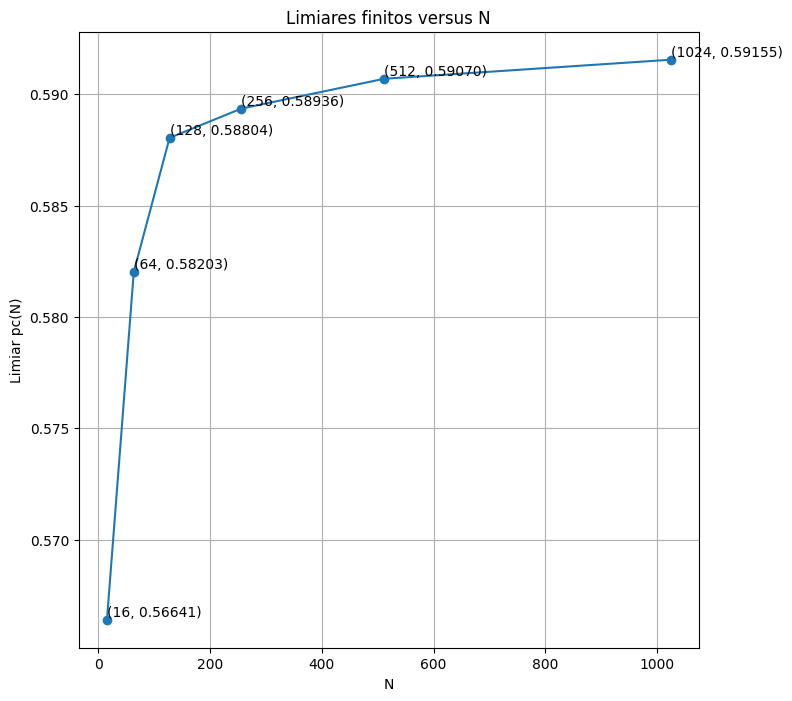

In [9]:
np.random.seed(42)
limiar_critico(500)

A partir desse resultado e do gráfico associado a ele, podemos responder duas das principais perguntas do projeto:
> - Qual o valor de $p$ a partir do qual um "caminho" de ponta a ponta na grade se torna provável?
> - Como essa probabilidade varia com o tamanho da grade ($N$)?

Os limiares finitos estimados $\widehat{p_c}(N)$ representam os valores de $p$ a partir dos quais um "caminho" de ponta a ponta na grade -- isto é, a percolação -- se torna provável para cada tamanho de grade, e o gráfico plotado acima ilustra como esse valor varia de acordo com esse tamanho. Percebe-se que o valor escala rapidamente em relação ao tamanho da grade para tamanhos abaixo de $N=128$, mas tende a se estabilizar entre $0.589$ e $0.592$ quando $N$ cresce após essa marca.

### **Distribuição empírica do tamanho do maior cluster em $\widehat{p_c}(N)$**

Invocando as funções `metricas_cluster` e `encontrar_limiar`, construímos gráficos da distribuição empírica do tamanho do maior cluster com $p = \widehat{p_c}(N)$ para cada $N \in \{64, 128, 256, 512\}$, usando $M=500$ réplicas.

Esses gráficos ilustram bem a resposta para mais uma das perguntas do projeto:
> - Qual a distribuição de tamanho do maior aglomerado _(cluster)_ de sítios conectados, especialmente no limiar crítico?

In [ ]:
def grafico_tam_clusters(N, p, M):
  '''Os parâmetros são os mesmos da função metricas_cluster(N, p, M). 
  Retorna gráficos contendo métricas e a distribuição do tamanho do maior cluster para os casos em que percola (esquerda)
  e que não percola (direita)'''
  dados = metricas_cluster(N, p, M)
  tam_cluster_percola, tam_cluster_nao_percola, prob_percolar, prob_nao_percolar, media_tam_percola, media_tam_nao_percola, total_percola, total_nao_percola, num_cluster_percola, num_cluster_nao_percola, media_num_percola, media_num_nao_percola = dados

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Histograma para sistemas que percolam
  axes[0].hist(tam_cluster_percola, bins=30, edgecolor='black')
  axes[0].set_title(f"Percolou\n θ(p, N)={prob_percolar:.3f} | Média={media_tam_percola:.2f} | Total de matrizes: {total_percola} | Máximo: {max(tam_cluster_percola)}")
  axes[0].set_xlabel("Tamanho do maior cluster")
  axes[0].set_ylabel("Frequência")
  axes[0].grid(True)

  # Histograma para sistemas que NÃO percolam
  axes[1].hist(tam_cluster_nao_percola, bins=30, edgecolor='black')
  axes[1].set_title(f"Não Percolou\n θ(p, N)={prob_nao_percolar:.3f} | Média={media_tam_nao_percola:.2f} | Total de matrizes: {total_nao_percola} | Máximo: {max(tam_cluster_nao_percola)}")
  axes[1].set_xlabel("Tamanho do maior cluster")
  axes[1].grid(True)

  plt.suptitle(f"Distribuição do tamanho dos maiores clusters (N={N}, p={p:.4f}, M={M})", fontsize=16)
  plt.tight_layout()
  plt.show()

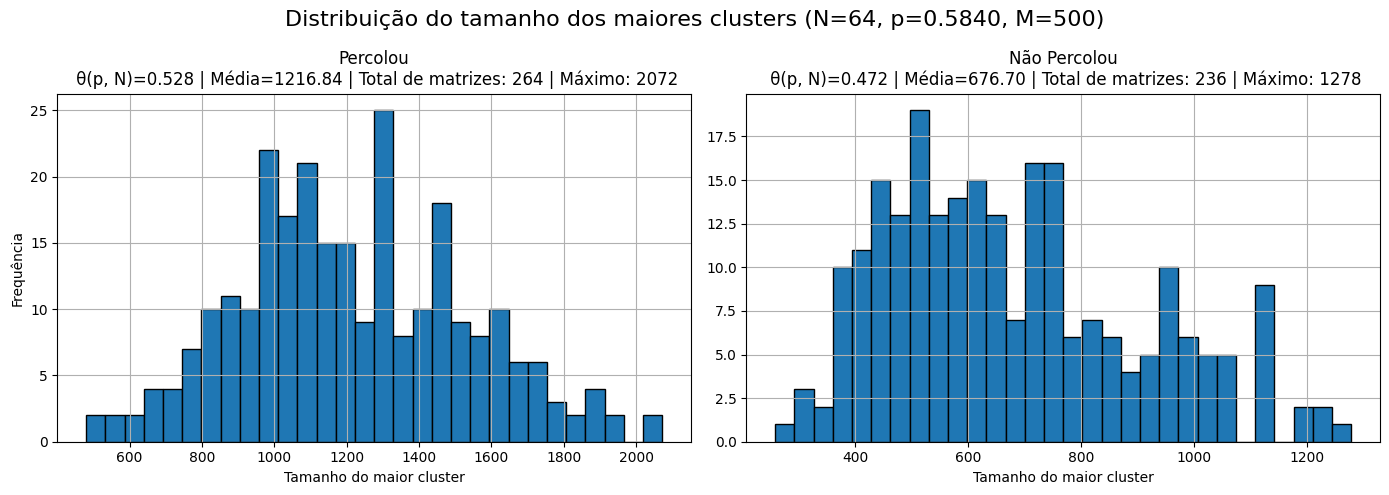

In [ ]:
np.random.seed(42)
N = 64
M = 500
p = encontrar_limiar(N, M)
grafico_tam_clusters(N, p, M)

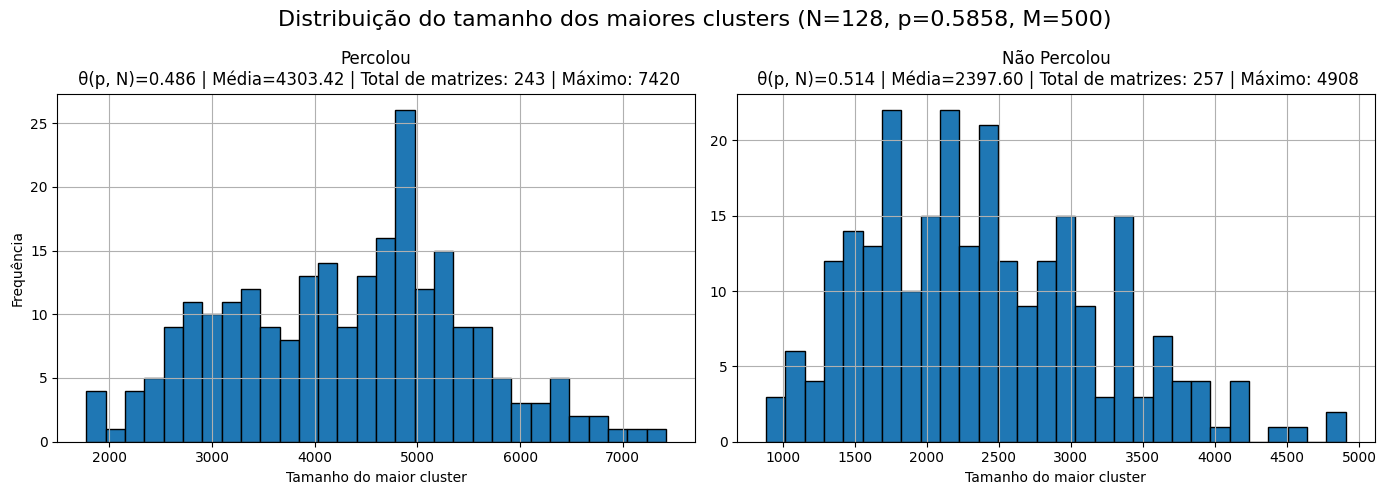

In [ ]:
np.random.seed(42)
N = 128
M = 500
p = encontrar_limiar(N, M)
grafico_tam_clusters(N, p, M)

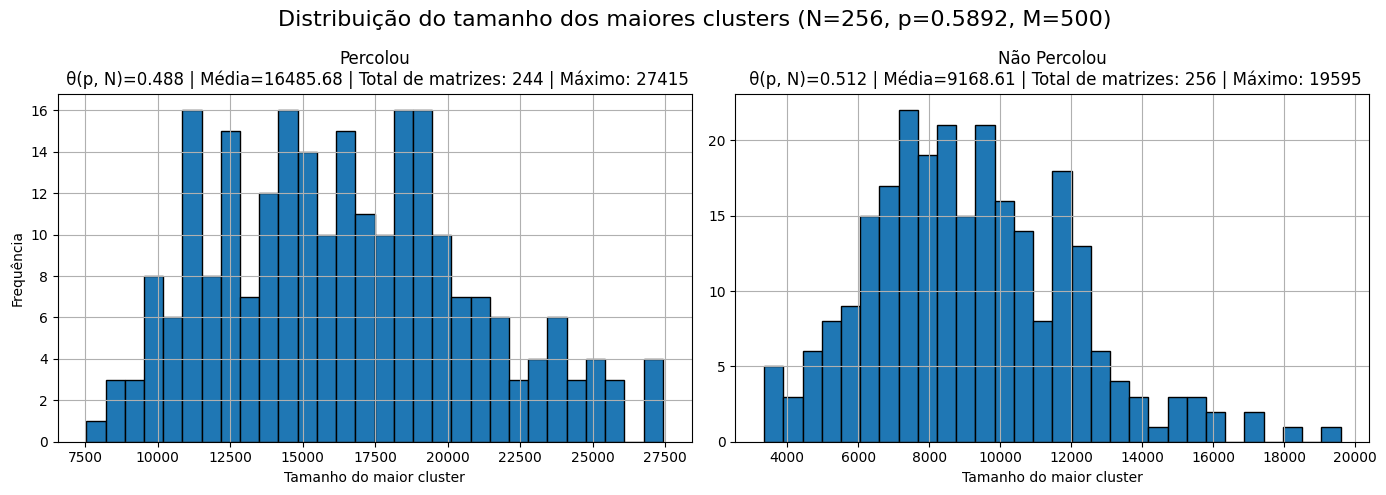

In [ ]:
np.random.seed(42)
N = 256
M = 500
p = encontrar_limiar(N, M)
grafico_tam_clusters(N, p, M)

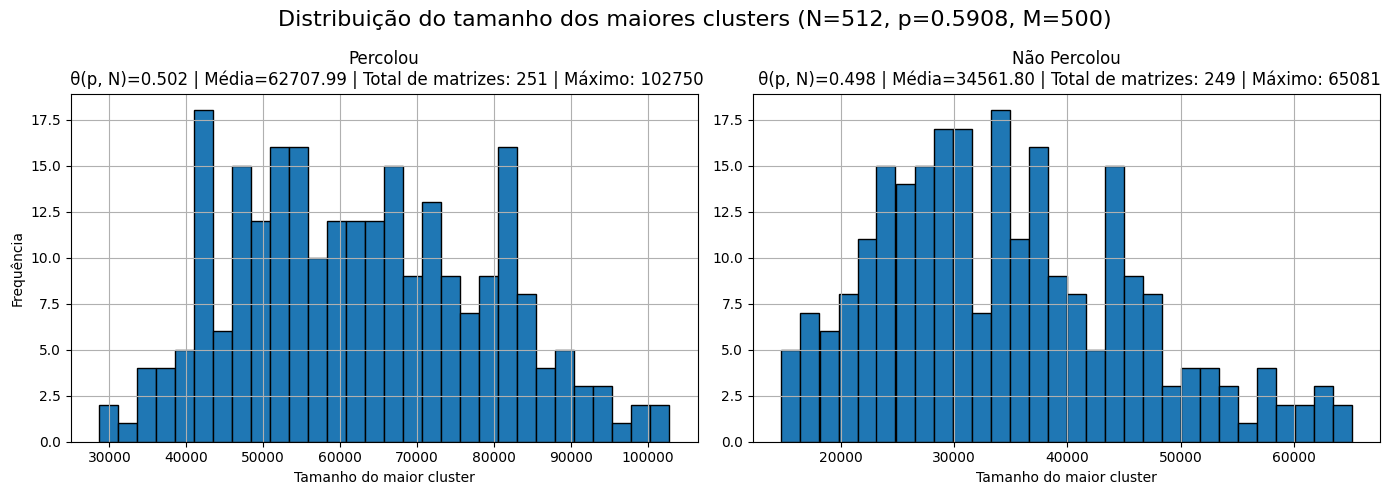

In [ ]:
np.random.seed(42)
N = 512
M = 500
p = encontrar_limiar(N, M)
grafico_tam_clusters(N, p, M)

### **Distribuição empírica do número de clusters em $\widehat{p_c}(N)$**

De forma análoga ao gráfico anterior, geramos gráficos a respeito do número de clusters para sistemas com $p = \widehat{p_c}(N)$ para cada $N \in \{64, 128, 256, 512\}$, usando $M=500$ réplicas.

In [29]:
def grafico_num_clusters(N, p, M):
  '''Os parâmetros são os mesmos da função media_cluster(N, p, M). 
  Gera dois gráficos comparativos com as métricas dos sistemas/matrizes que percolam e que não percolam,
  comparando a distribuição do total de clusters'''
  dados = metricas_cluster(N, p, M)
  tam_cluster_percola, tam_cluster_nao_percola, prob_percolar, prob_nao_percolar, media_tam_percola, media_tam_nao_percola, total_percola, total_nao_percola, num_cluster_percola, num_cluster_nao_percola, media_num_percola, media_num_nao_percola = dados

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Histograma para sistemas que percolam
  axes[0].hist(num_cluster_percola, bins=30, edgecolor='black')
  axes[0].set_title(f"Percolou \nMédia={media_num_percola:.2f} | Total de matrizes: {total_percola} | Máximo: {max(num_cluster_percola)}")
  axes[0].set_xlabel("Número total de clusters")
  axes[0].set_ylabel("Frequência")
  axes[0].grid(True)

  # Histograma para sistemas que NÃO percolam
  axes[1].hist(num_cluster_nao_percola, bins=30, edgecolor='black')
  axes[1].set_title(f"Não percolou \nMédia={media_num_nao_percola:.2f} | Total de matrizes: {total_nao_percola} | Máximo: {max(num_cluster_nao_percola)}")
  axes[1].set_xlabel("Número total de clusters")
  axes[1].grid(True)

  plt.suptitle(f"Distribuição do número de clusters (N={N}, p={p:.4f}, M={M})", fontsize=16)
  plt.tight_layout()
  plt.show()

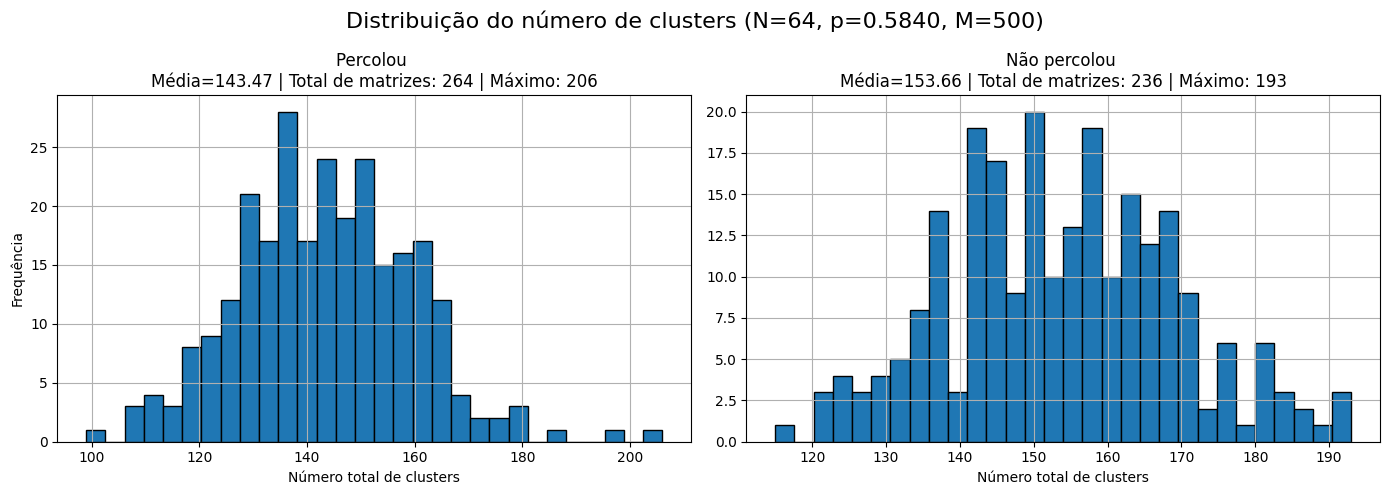

In [ ]:
np.random.seed(42)
N = 64
M = 500
p = encontrar_limiar(N, M)
grafico_num_clusters(N, p, M)

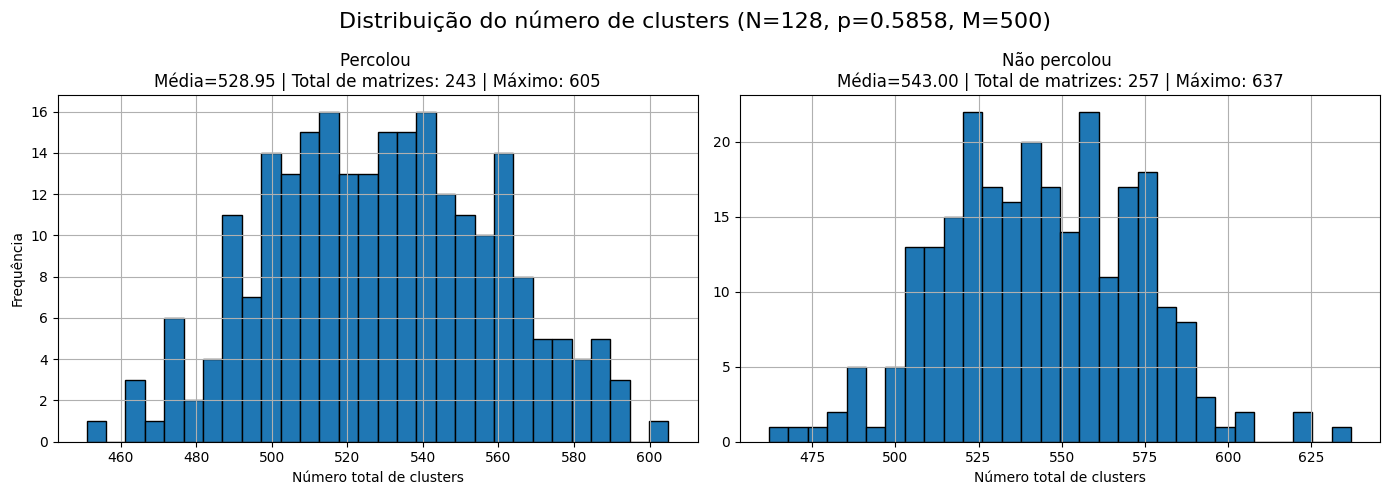

In [ ]:
np.random.seed(42)
N = 128
M = 500
p = encontrar_limiar(N, M)
grafico_num_clusters(N, p, M)

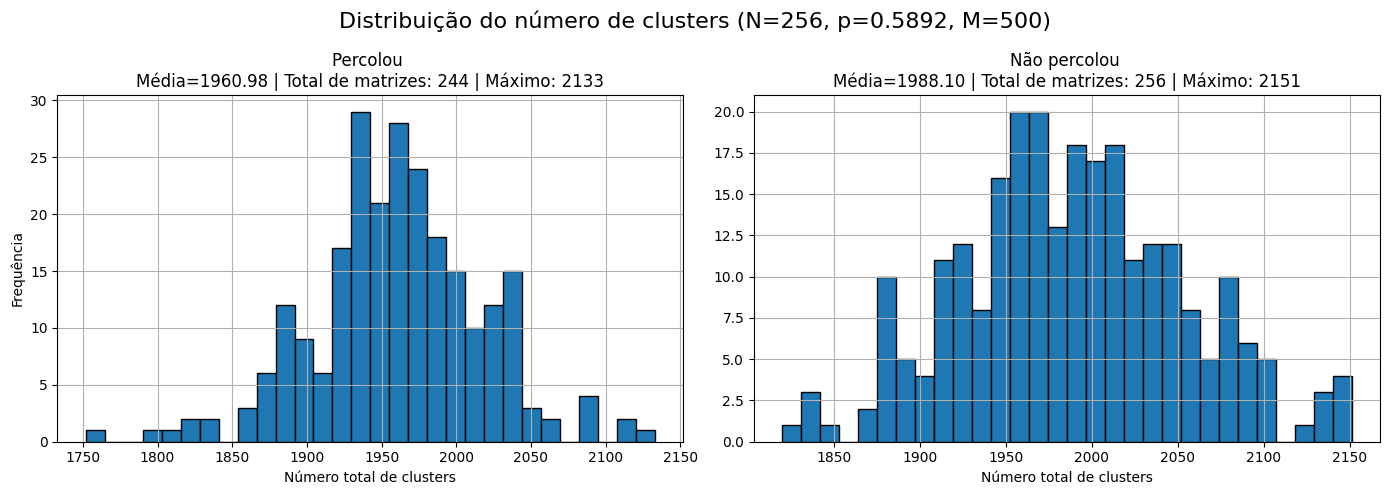

In [ ]:
np.random.seed(42)
N = 256
M = 500
p = encontrar_limiar(N, M)
grafico_num_clusters(N, p, M)

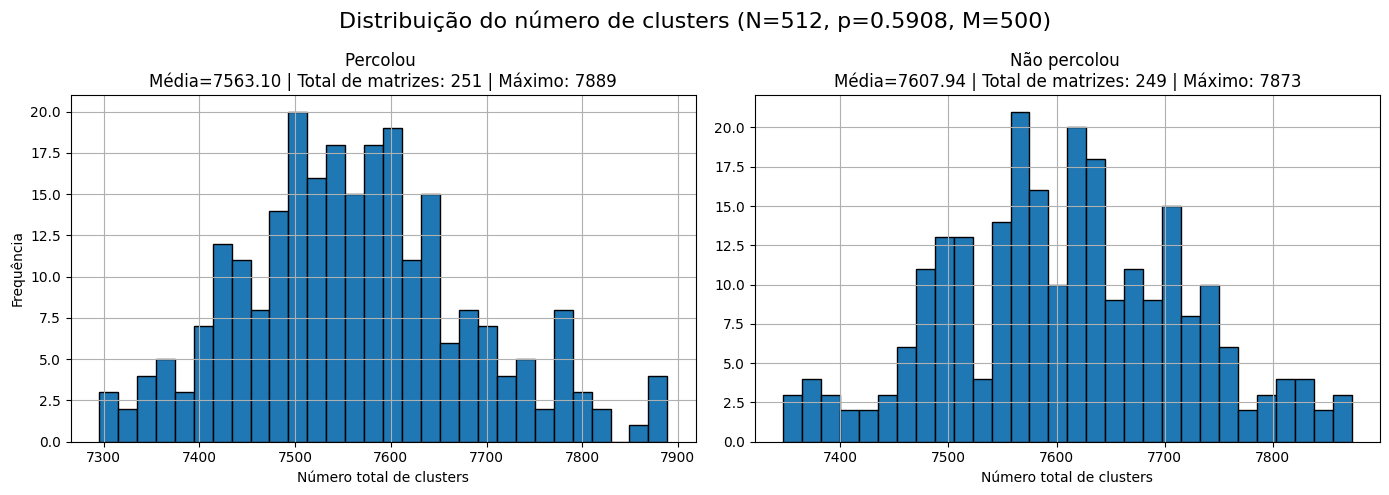

In [ ]:
np.random.seed(42)
N = 512
M = 500
p = encontrar_limiar(N, M)
grafico_num_clusters(N, p, M)

### **Boxplots: número de clusters e tamanho do maior cluster em $\widehat{p_c}(N)$**

Representamos os resultados expostos anteriormente sobre número de clusters e tamanho do maior cluster para cada $N$ também em formato de boxplots, para fins de comparação e resumo estatístico.

In [18]:
# Boxplot para o tamanho do maior cluster obtido em cada simulação
def boxplot_tam_clusters(N, p, M):
    dados1 = []
    for i in range(M):
        dados1.append(simulacao_percolacao(N, p)[1])

    dados1 = np.array(dados1)

    plt.boxplot(dados1, patch_artist=True, boxprops=dict(facecolor='Orange'), medianprops=dict(color='black', linewidth=2))
    plt.title(f'Boxplot do tamanho do maior cluster em cada uma das \n{M} simulações com N = {N} e p = {p:.4f}')
    plt.grid(True)
    plt.show()

    print(f"Medidas resumo do tamanho do maior cluster em cada uma das {M} simulações com N = {N} e p = {p:.4f}")
    print(f'Mínimo: {dados1.min()} | 1º Q: {np.quantile(dados1, 0.25)} | Mediana: {np.quantile(dados1, 0.5)} | 3º Q: {np.quantile(dados1, 0.75)} | Máximo: {dados1.max()}')

# Boxplot para o total de clusters obtido em cada simulação
def boxplot_num_clusters(N, p, M):
    dados2 = []
    for i in range(M):
        dados2.append(simulacao_percolacao(N, p)[2])

    dados2 = np.array(dados2)

    plt.boxplot(dados2, patch_artist=True, boxprops=dict(facecolor='Orange'), medianprops=dict(color='black', linewidth=2))
    plt.title(f'Boxplot do total de clusters em cada uma das \n{M} simulações com N = {N} e p = {p:.4f}')
    plt.grid(True)
    plt.show()

    print(f"Medidas resumo do total de clusters em cada uma das {M} simulações com N = {N} e p = {p:.4f}")
    print(f'Mínimo: {dados2.min()} | 1º Q: {np.quantile(dados2, 0.25)} | Mediana: {np.quantile(dados2, 0.5)} | 3º Q: {np.quantile(dados2, 0.75)} | Máximo: {dados2.max()}')

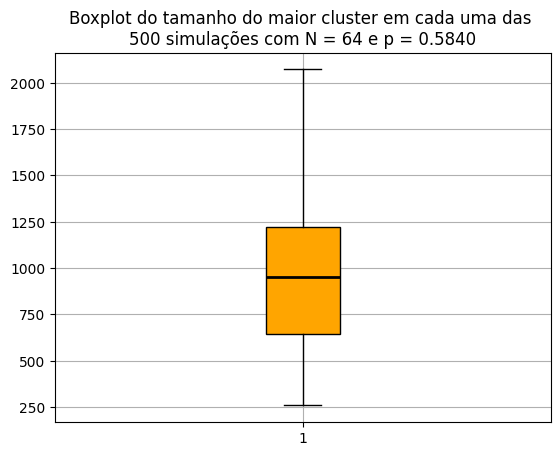

Medidas resumo do tamanho do maior cluster em cada uma das 500 simulações com N = 64 e p = 0.5840
Mínimo: 258 | 1º Q: 642.75 | Mediana: 949.5 | 3º Q: 1221.25 | Máximo: 2072


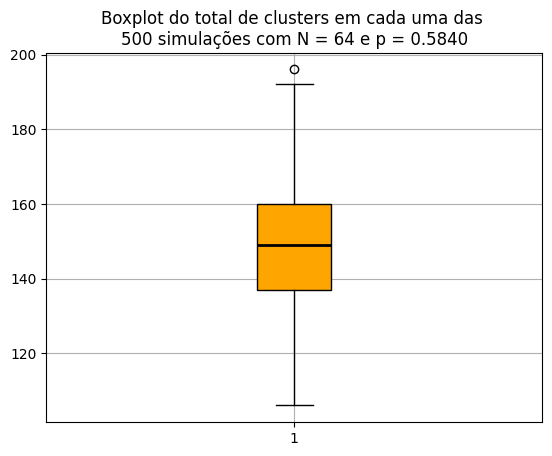

Medidas resumo do total de clusters em cada uma das 500 simulações com N = 64 e p = 0.5840
Mínimo: 106 | 1º Q: 137.0 | Mediana: 149.0 | 3º Q: 160.0 | Máximo: 196


In [23]:
np.random.seed(42)
N = 64
M = 500
p = encontrar_limiar(N, M)
boxplot_tam_clusters(N, p, M)
boxplot_num_clusters(N, p, M)

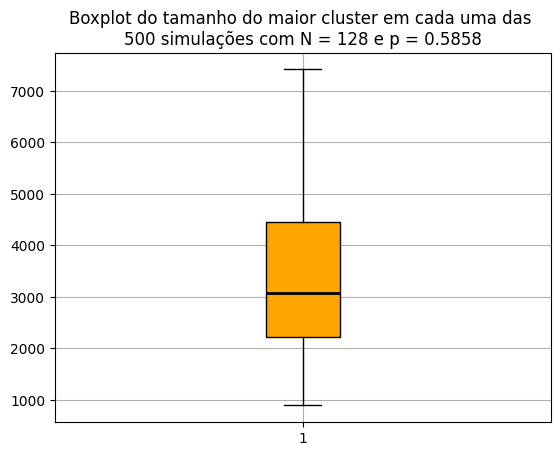

Medidas resumo do tamanho do maior cluster em cada uma das 500 simulações com N = 128 e p = 0.5858
Mínimo: 885 | 1º Q: 2211.75 | Mediana: 3076.5 | 3º Q: 4446.75 | Máximo: 7420


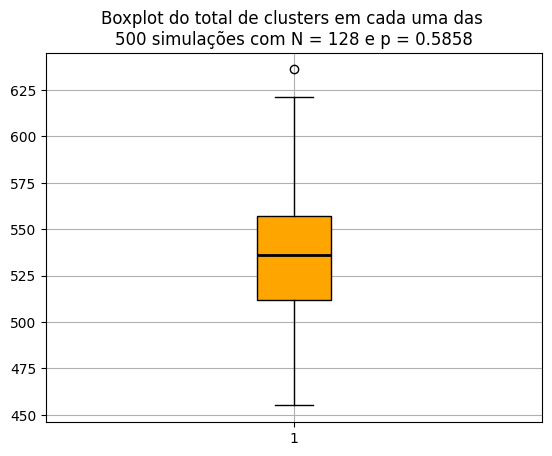

Medidas resumo do total de clusters em cada uma das 500 simulações com N = 128 e p = 0.5858
Mínimo: 455 | 1º Q: 512.0 | Mediana: 536.0 | 3º Q: 557.0 | Máximo: 636


In [24]:
np.random.seed(42)
N = 128
M = 500
p = encontrar_limiar(N, M)
boxplot_tam_clusters(N, p, M)
boxplot_num_clusters(N, p, M)

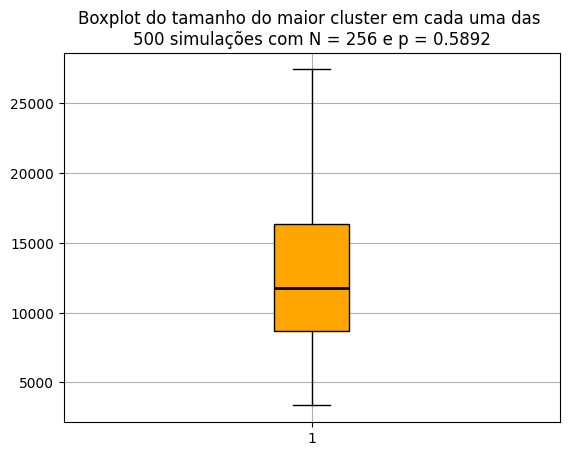

Medidas resumo do tamanho do maior cluster em cada uma das 500 simulações com N = 256 e p = 0.5892
Mínimo: 3348 | 1º Q: 8703.25 | Mediana: 11783.0 | 3º Q: 16356.75 | Máximo: 27415


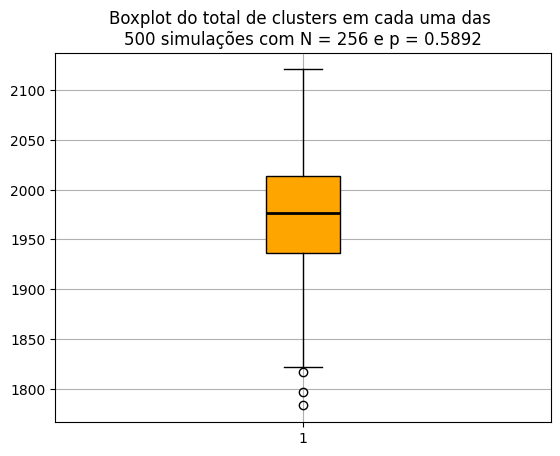

Medidas resumo do total de clusters em cada uma das 500 simulações com N = 256 e p = 0.5892
Mínimo: 1783 | 1º Q: 1936.0 | Mediana: 1977.0 | 3º Q: 2014.0 | Máximo: 2121


In [25]:
np.random.seed(42)
N = 256
M = 500
p = encontrar_limiar(N, M)
boxplot_tam_clusters(N, p, M)
boxplot_num_clusters(N, p, M)

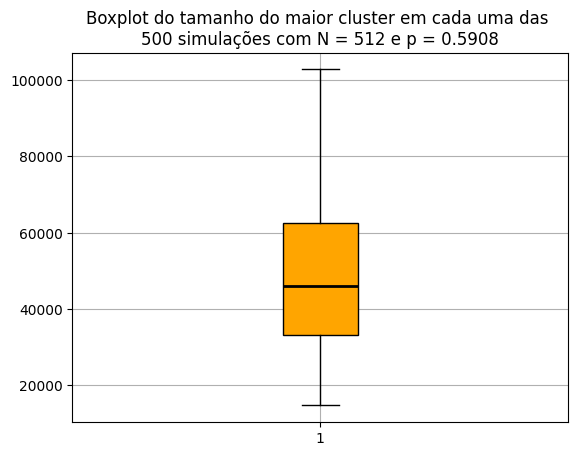

Medidas resumo do tamanho do maior cluster em cada uma das 500 simulações com N = 512 e p = 0.5908
Mínimo: 14764 | 1º Q: 33199.5 | Mediana: 46175.0 | 3º Q: 62537.5 | Máximo: 102750


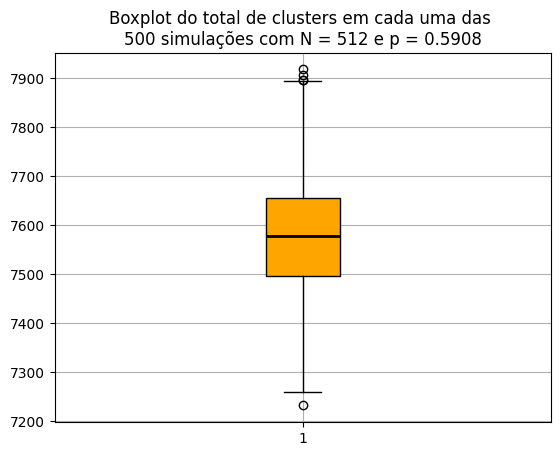

Medidas resumo do total de clusters em cada uma das 500 simulações com N = 512 e p = 0.5908
Mínimo: 7232 | 1º Q: 7495.0 | Mediana: 7577.5 | 3º Q: 7654.5 | Máximo: 7917


In [26]:
np.random.seed(42)
N = 512
M = 500
p = encontrar_limiar(N, M)
boxplot_tam_clusters(N, p, M)
boxplot_num_clusters(N, p, M)